In [ ]:
! pip install openmeteo-requests
! pip install requests-cache retry-requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.4 MB/s eta 0:00:00


In [ ]:
# Packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import math
import seaborn as sns
import matplotlib.colors as cm
import calendar
import time

# Imports
from datetime import date

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Map initialization

Let's make the map first

In [ ]:
# Initializing the map
filepath = r'/content/drive/MyDrive/Philippines shapefile/gadm41_PHL_1.shp'
PHL = gpd.read_file(filepath)

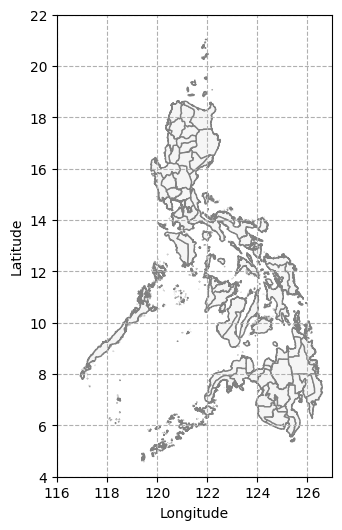

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))
# Axes
ax = PHL.plot(ax=ax, figsize=(10,10), color='whitesmoke', edgecolor='gray')
ax.set_xlim(116, 127)
ax.set_ylim(4, 22)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(linestyle='--')

In [ ]:
mesh_points = []

for x_point in range(116, 127):
  for y_point in range(4, 22):
    mesh_points.append([x_point, y_point])

In [ ]:
dx_theo = 0.25
y_values = np.arange(4, 22, dx_theo)
x_values = np.arange(116, 127, dx_theo)

x_mesh, y_mesh = np.meshgrid(x_values, y_values)
xy_points = np.vstack([x_mesh.ravel(), y_mesh.ravel()]).T

In [ ]:
dx, dy = np.abs(x_values[1] - x_values[0]), np.abs(y_values[1] - y_values[0])

In [ ]:
# Converting the mesh of points into a geodataframe
geo_points = gpd.GeoDataFrame(xy_points, geometry=gpd.points_from_xy(xy_points[:, 0], xy_points[:, 1]))
geo_points.crs = PHL.crs # making the coordinate system of the two the same

# Intersecting the points to the shapefile
phl_points = gpd.sjoin(geo_points, PHL, how='inner', predicate='within')
phl_points

,0,1,geometry,index_right,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1
146,119.50,4.75,POINT (119.50000 4.75000),76,PHL.77_1,PHL,Philippines,Tawi-Tawi,NA,NA,Lalawigan,Province,1570,PH.TT,PH-TAW
192,120.00,5.00,POINT (120.00000 5.00000),76,PHL.77_1,PHL,Philippines,Tawi-Tawi,NA,NA,Lalawigan,Province,1570,PH.TT,PH-TAW
538,118.50,7.00,POINT (118.50000 7.00000),76,PHL.77_1,PHL,Philippines,Tawi-Tawi,NA,NA,Lalawigan,Province,1570,PH.TT,PH-TAW
345,125.25,5.75,POINT (125.25000 5.75000),66,PHL.67_1,PHL,Philippines,Sarangani,NA,NA,Lalawigan,Province,1280,PH.SG,PH-SAR
387,124.75,6.00,POINT (124.75000 6.00000),66,PHL.67_1,PHL,Philippines,Sarangani,NA,NA,Lalawigan,Province,1280,PH.SG,PH-SAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2573,121.25,18.50,POINT (121.25000 18.50000),17,PHL.18_1,PHL,Philippines,Cagayan,NA,NA,Lalawigan,Province,215,PH.CG,PH-CAG
2482,120.50,18.00,POINT (120.50000 18.00000),33,PHL.34_1,PHL,Philippines,Ilocos Norte,NA,NA,Lalawigan,Province,128,PH.IN,PH-ILN
2483,120.75,18.00,POINT (120.75000 18.00000),33,PHL.34_1,PHL,Philippines,Ilocos Norte,NA,NA,Lalawigan,Province,128,PH.IN,PH-ILN
2527,120.75,18.25,POINT (120.75000 18.25000),33,PHL.34_1,PHL,Philippines,Ilocos Norte,NA,NA,Lalawigan,Province,128,PH.IN,PH-ILN


In [ ]:
# Getting only the coordinates and not the other columns in the PHL shapefile
points_in_phl = phl_points[[0, 1, 'geometry']]
points_in_phl.columns = ['coord.lon', 'coord.lat', 'geometry']
points_in_phl.reset_index(drop=True, inplace=True)

# Making the points have a buffer
square_points = points_in_phl.to_crs(crs=PHL.crs).buffer(dx_theo/2, cap_style=3) # dx_theo/2 is the size of buffer, cap_style=3 makes it square
square_points.reset_index(drop=True, inplace=True)

<ipython-input-10-ad576262bb81>:7: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  square_points = points_in_phl.to_crs(crs=PHL.crs).buffer(dx_theo/2, cap_style=3) # dx_theo/2 is the size of buffer, cap_style=3 makes it square


## OpenMeteo API

In [ ]:
# OpenMeteo API
import openmeteo_requests
import requests_cache
from retry_requests import retry


# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [ ]:
def get_data(coord_lat, coord_lon, date_start, date_end):
  # Make sure all required weather variables are listed here
  # The order of variables in hourly or daily is important to assign them correctly below
  # Coordinates are floats
  # Date is of the format YYYY-MM-DD and should be a string
  url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
  params = {
    "latitude": coord_lat, # x-values
    "longitude": coord_lon, # y-values
    "start_date": date_start,
    "end_date": date_end,
    "daily": ["temperature_2m_max", "temperature_2m_min", "rain_sum", "wind_speed_10m_max"],
    "timezone": "Asia/Singapore"
  }
  responses = openmeteo.weather_api(url, params=params)

  # Process first location. Add a for-loop for multiple locations or weather models
  response = responses[0]
  print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
  print(f"Elevation {response.Elevation()} m asl")
  print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
  print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

  # Process daily data. The order of variables needs to be the same as requested.
  daily = response.Daily()
  daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
  daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
  daily_rain_sum = daily.Variables(2).ValuesAsNumpy()
  daily_wind_speed_10m_max = daily.Variables(3).ValuesAsNumpy()

  daily_data = {"date": pd.date_range(
    start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
    end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = daily.Interval()),
    inclusive = "left"
  )}
  daily_data["temperature_2m_max"] = daily_temperature_2m_max
  daily_data["temperature_2m_min"] = daily_temperature_2m_min
  daily_data["rain_sum"] = daily_rain_sum
  daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max

  daily_dataframe = pd.DataFrame(data = daily_data)
  return daily_dataframe

In [ ]:
def get_weather_data(point_list, year):
  iteration = 0
  all_weather_data = []

  # Start and end dates
  if year == 2024:
    date_start = f'2024-01-01'
    date_end = date.today().strftime("%Y-%m-%d")
  else:
    date_start = f'{year}-01-01'
    date_end = f'{year}-12-30'

  for index in range(len(point_list)):
    # Loop sleeps for 1 minute every 50 cities for the API to recover
    if iteration % 50 == 0 and iteration !=0:
      print(f'Waiting...')
      time.sleep(60)
      print(f'Iteration: {iteration}')
      city_weather = get_data(point_list.iloc[index]['coord.lat'], point_list.iloc[index]['coord.lon'], date_start, date_end)
      all_weather_data.append(city_weather)
      iteration += 1
    elif iteration == len(point_list):
      print(f'Waiting...')
      time.sleep(60)
    else:
      print(f'Iteration: {iteration}')
      city_weather = get_data(point_list.iloc[index]['coord.lat'], point_list.iloc[index]['coord.lon'], date_start, date_end)
      all_weather_data.append(city_weather)
      iteration += 1

  return all_weather_data

## Wag to

In [ ]:
len(points_in_phl)

396

In [ ]:
data_2019 = get_weather_data(points_in_phl, 2019)

Iteration: 0
Coordinates 4.75°N 119.5°E
Elevation 10.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 1
Coordinates 5.125°N 120.125°E
Elevation 4.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 2
Coordinates 7.0°N 118.5°E
Elevation 40.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 3
Coordinates 5.75°N 125.25°E
Elevation 51.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 4
Coordinates 6.0°N 124.75°E
Elevation 516.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 5
Coordinates 6.0°N 125.0°E
Elevation 628.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 6
Coordinates 6.0°N 125.5°E
Elevation 1209.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 7
Coordinates 5.625°N 125.375°E
Elevation 239.0 m asl
Timezon

In [ ]:
data_2020 = get_weather_data(points_in_phl, 2020)

Iteration: 0
Coordinates 4.75°N 119.5°E
Elevation 10.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 1
Coordinates 5.125°N 120.125°E
Elevation 4.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 2
Coordinates 7.0°N 118.5°E
Elevation 40.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 3
Coordinates 5.75°N 125.25°E
Elevation 51.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 4
Coordinates 6.0°N 124.75°E
Elevation 516.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 5
Coordinates 6.0°N 125.0°E
Elevation 628.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 6
Coordinates 6.0°N 125.5°E
Elevation 1209.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 7
Coordinates 5.625°N 125.375°E
Elevation 239.0 m asl
Timezon

In [ ]:
data_2023 = get_weather_data(points_in_phl, 2023)

Iteration: 0
Coordinates 4.75°N 119.5°E
Elevation 10.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 1
Coordinates 5.125°N 120.125°E
Elevation 4.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 2
Coordinates 7.0°N 118.5°E
Elevation 40.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 3
Coordinates 5.75°N 125.25°E
Elevation 51.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 4
Coordinates 6.0°N 124.75°E
Elevation 516.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 5
Coordinates 6.0°N 125.0°E
Elevation 628.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 6
Coordinates 6.0°N 125.5°E
Elevation 1209.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 7
Coordinates 5.625°N 125.375°E
Elevation 239.0 m asl
Timezon

In [ ]:
data_2023[0]

,date,temperature_2m_max,temperature_2m_min,rain_sum,wind_speed_10m_max
0,2022-12-31 16:00:00+00:00,28.785000,26.135000,0.0,14.917212
1,2023-01-01 16:00:00+00:00,27.785000,26.334999,0.0,19.855558
2,2023-01-02 16:00:00+00:00,27.334999,26.084999,0.0,16.422470
3,2023-01-03 16:00:00+00:00,28.334999,25.984999,0.0,11.753876
4,2023-01-04 16:00:00+00:00,28.334999,26.535000,0.0,13.698934
...,...,...,...,...,...
359,2023-12-25 16:00:00+00:00,28.785000,26.885000,0.0,7.421590
360,2023-12-26 16:00:00+00:00,28.834999,26.635000,0.0,9.885262
361,2023-12-27 16:00:00+00:00,28.934999,27.135000,0.0,11.753877
362,2023-12-28 16:00:00+00:00,28.834999,27.734999,0.0,12.727921


In [ ]:
data_201920 = [pd.concat([data_2019[idx], data_2020[idx]]) for idx in range(len(points_in_phl))]

In [ ]:
for idx in range(len(points_in_phl)):
  data_2023[idx].to_csv(f'iteration {idx}.csv')

In [ ]:
! mkdir iteration_data_23 | mv *.csv iteration_data_23/

In [ ]:
! zip -r data_23.zip iteration_data_23/

  adding: iteration_data_23/ (stored 0%)
  adding: iteration_data_23/iteration 363.csv (deflated 76%)
  adding: iteration_data_23/iteration 123.csv (deflated 76%)
  adding: iteration_data_23/iteration 62.csv (deflated 77%)
  adding: iteration_data_23/iteration 268.csv (deflated 75%)
  adding: iteration_data_23/iteration 264.csv (deflated 75%)
  adding: iteration_data_23/iteration 81.csv (deflated 76%)
  adding: iteration_data_23/iteration 87.csv (deflated 76%)
  adding: iteration_data_23/iteration 293.csv (deflated 75%)
  adding: iteration_data_23/iteration 221.csv (deflated 75%)
  adding: iteration_data_23/iteration 131.csv (deflated 76%)
  adding: iteration_data_23/iteration 202.csv (deflated 74%)
  adding: iteration_data_23/iteration 151.csv (deflated 76%)
  adding: iteration_data_23/iteration 314.csv (deflated 75%)
  adding: iteration_data_23/iteration 309.csv (deflated 76%)
  adding: iteration_data_23/iteration 379.csv (deflated 75%)
  adding: iteration_data_23/iteration 278.csv (

- ```weather_data[0]``` is the 2019 data
- ```weather_data[0]``` is 2019's first city data

In [ ]:
from google.colab import files

In [ ]:
files.download(data.zip)

NameError: name 'data' is not defined

In [ ]:
weather_data[4][0]

,date,temperature_2m_max,temperature_2m_min,rain_sum,wind_speed_10m_max
0,2022-12-31 16:00:00+00:00,28.785000,26.135000,0.0,14.917212
1,2023-01-01 16:00:00+00:00,27.785000,26.334999,0.0,19.855558
2,2023-01-02 16:00:00+00:00,27.334999,26.084999,0.0,16.422470
3,2023-01-03 16:00:00+00:00,28.334999,25.984999,0.0,11.753876
4,2023-01-04 16:00:00+00:00,28.334999,26.535000,0.0,13.698934
...,...,...,...,...,...
359,2023-12-25 16:00:00+00:00,28.785000,26.885000,0.0,7.421590
360,2023-12-26 16:00:00+00:00,28.834999,26.635000,0.0,9.885262
361,2023-12-27 16:00:00+00:00,28.934999,27.135000,0.0,11.753877
362,2023-12-28 16:00:00+00:00,28.834999,27.734999,0.0,12.727921


In [ ]:
pd.concat([weather_data[i] for i in range(5)])

,date,temperature_2m_max,temperature_2m_min,rain_sum,wind_speed_10m_max
0,2022-12-31 16:00:00+00:00,28.785000,26.135000,0.0,14.917212
1,2023-01-01 16:00:00+00:00,27.785000,26.334999,0.0,19.855558
2,2023-01-02 16:00:00+00:00,27.334999,26.084999,0.0,16.422470
3,2023-01-03 16:00:00+00:00,28.334999,25.984999,0.0,11.753876
4,2023-01-04 16:00:00+00:00,28.334999,26.535000,0.0,13.698934
...,...,...,...,...,...
359,2023-12-25 16:00:00+00:00,28.785000,26.885000,0.0,7.421590
360,2023-12-26 16:00:00+00:00,28.834999,26.635000,0.0,9.885262
361,2023-12-27 16:00:00+00:00,28.934999,27.135000,0.0,11.753877
362,2023-12-28 16:00:00+00:00,28.834999,27.734999,0.0,12.727921


## Cont.

In [ ]:
import os
import zipfile
from natsort import natsorted

This looks for the zip files that are in the Google Drive

In [ ]:
zip_files = os.listdir('/content/drive/MyDrive/Colab Notebooks/Weather clustering data/OpenMeteo data')
zip_files.sort()

In [ ]:
zip_files

['data_201920.zip', 'data_2021.zip', 'data_2022.zip', 'data_2023.zip']

We then want to unzip all of the zip files into temporary folders here.

In [ ]:
folder_names = [zip_file_dir[:-4] for zip_file_dir in zip_files] # take each element of zip_files folder and remove .zip

for i in range(len(zip_files)):
  if not os.path.exists(f'/content/drive/MyDrive/Colab Notebooks/Weather clustering data/OpenMeteoFolder/{folder_names[i]}'):
    ! mkdir OpenMeteoFolder/{folder_names[i]}
  with zipfile.ZipFile(f'/content/drive/MyDrive/Colab Notebooks/Weather clustering data/OpenMeteo data/{zip_files[i]}', 'r') as zip_ref:
      zip_ref.extractall(f'/content/drive/MyDrive/Colab Notebooks/Weather clustering data/OpenMeteoFolder/{folder_names[i]}')

In [ ]:
openmeteo_files = os.listdir('/content/drive/MyDrive/Colab Notebooks/Weather clustering data/OpenMeteoFolder')
openmeteo_files.sort()

In [ ]:
iteration_list = natsorted(os.listdir('/content/drive/MyDrive/Colab Notebooks/Weather clustering data/OpenMeteoFolder/data_201920/iteration_data'))

In [ ]:
openmeteo_weather = []
for folder in openmeteo_files:
  data_folder = []
  openmeteo_weather.append(data_folder)
  for iteration in iteration_list:
    data = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Weather clustering data/OpenMeteoFolder/{folder}/iteration_data/{iteration}', index_col=0)
    data['date'] = pd.to_datetime(data['date']).dt.tz_localize(None)
    data.set_index('date', inplace=True)
    data_folder.append(data)

In [ ]:
for year in openmeteo_weather:
  print(np.array(year).shape)

(396, 729, 4)
(396, 364, 4)
(396, 364, 4)
(396, 364, 4)


Let's check the 2022 rainfall data of the first city.

In [ ]:
a = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Weather clustering data/OpenMeteoFolder/data_2022/iteration_data/iteration 0.csv', index_col=0)
a['date'] = pd.to_datetime(a['date']).dt.tz_localize(None)
a.set_index('date', inplace=True)
a_res = a.resample('7d').mean()

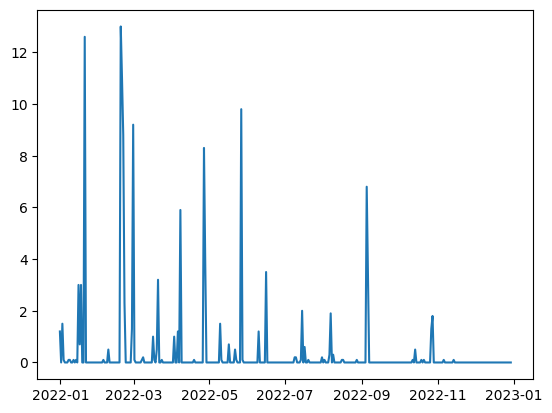

In [ ]:
plt.plot(a['rain_sum'])

To get the error between each week, we need to turn this into an array. However, if you put in

<center>

```np.array(data_full)```

</center>

It will give you an error. That is why we have to concatenate the data first, resample them, then make it into an array.

Finally, let's get the data from 2024. This updates daily so we can only get it from the API.

In [ ]:
get_data_2024 = get_weather_data(points_in_phl, 2024)

Iteration: 0
Coordinates 4.75°N 119.5°E
Elevation 10.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 1
Coordinates 5.125°N 120.125°E
Elevation 4.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 2
Coordinates 7.0°N 118.5°E
Elevation 40.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 3
Coordinates 5.75°N 125.25°E
Elevation 51.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 4
Coordinates 6.0°N 124.75°E
Elevation 516.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 5
Coordinates 6.0°N 125.0°E
Elevation 628.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 6
Coordinates 6.0°N 125.5°E
Elevation 1209.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 7
Coordinates 5.625°N 125.375°E
Elevation 239.0 m asl
Timezon

In [ ]:
data_2024 = []

for data in get_data_2024:
  data_ = data.copy()
  data_['date'] = pd.to_datetime(data['date']).dt.tz_localize(None)
  data_ = data_.set_index('date')
  data_2024.append(data_)

In [ ]:
data_201920, data_2021, data_2022, data_2023 = openmeteo_weather[0], openmeteo_weather[1], openmeteo_weather[2], openmeteo_weather[3]
data_full = []

for idx in range(len(data_201920)):
  data = pd.concat([data_201920[idx], data_2021[idx], data_2022[idx], data_2023[idx], data_2024[idx]]).drop_duplicates().dropna()
  data_full.append(data)

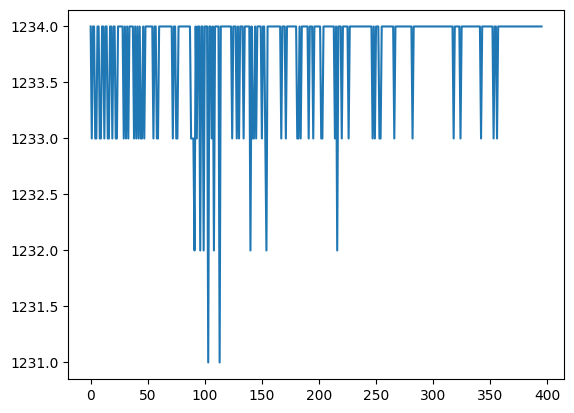

In [ ]:
data_lengths = [len(data) for data in data_full]
plt.plot(data_lengths)

We see that each dataframe in the list `data_full` has unequal lengths. However since we have to resample first, let's hope that the resampling will equalize the lengths of the dataframe.

In [ ]:
data_resample = [data.resample('7d').mean() for data in data_full]
resample_arr = np.array(data_resample)

In [ ]:
rainfall_arr = np.array([data['rain_sum'] for data in data_resample])
mean_rainfall = np.array([np.mean(rainfall_arr[date, :]) for date in range(len(rainfall_arr[0, :]))])
std_rainfall = np.array([np.std(rainfall_arr[date, :]) for date in range(len(rainfall_arr[0, :]))])

In [ ]:
rainfall_arr = np.array([data['rain_sum'] for data in data_resample])
mean_rainfall = np.array([np.std(rainfall_arr[:, i]) for i in range(len(rainfall_arr[0, :]))])
std_rainfall = np.array([np.std(rainfall_arr[:, i]) for i in range(len(rainfall_arr[0, :]))])

Now let's see how the standard deviation for each week looks

(array([18748., 18871., 18993., 19113., 19236., 19358., 19478., 19601.,
        19723., 19844., 19967.]),
 [Text(18748.0, 0, '2021-05'),
  Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01'),
  Text(19113.0, 0, '2022-05'),
  Text(19236.0, 0, '2022-09'),
  Text(19358.0, 0, '2023-01'),
  Text(19478.0, 0, '2023-05'),
  Text(19601.0, 0, '2023-09'),
  Text(19723.0, 0, '2024-01'),
  Text(19844.0, 0, '2024-05'),
  Text(19967.0, 0, '2024-09')])

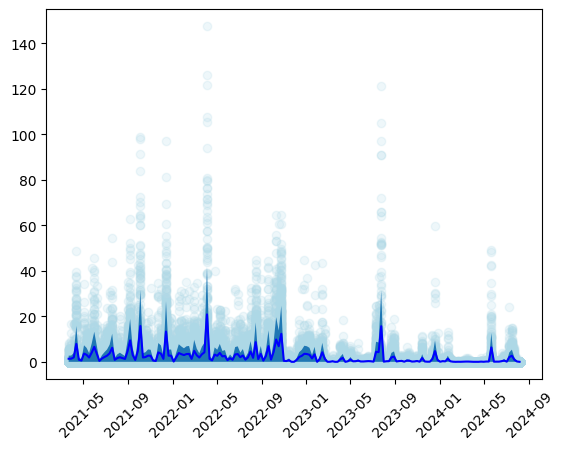

In [ ]:
dates = data_resample[0].index # date index of the first df in data_resample
for i in range(len(rainfall_arr)):
  plt.scatter(dates, rainfall_arr[i], color='lightblue', alpha=0.2)
plt.plot(dates, mean_rainfall, color='blue')
plt.fill_between(dates, mean_rainfall+std_rainfall, mean_rainfall-std_rainfall)
plt.xticks(rotation=45)

## City climate type

In [ ]:
filepath_climate = r'/content/drive/MyDrive/Philippines shapefile/Philippine ClimateType.geojson'
PHL_type = gpd.read_file(filepath_climate)

Now, we want to see what climate type each city belongs to. We could use `gpd.sjoin` to join two dataframes and see if points belong in a specific polygon or not. However, cities in the coast line may not be considered by the `sjoin` function. Thus, we want to use

<center>

```gpd.sjoin_nearest(left_df, right_df, how='inner', max_distance)```

</center>

to give the points a bit of a wiggle room and see which climate types they are closest to instead.

In [ ]:
points_in_phl.crs = PHL_type.crs # equalize the coordinates of the two gdf
city_inner = gpd.sjoin_nearest(points_in_phl, PHL_type, how="inner", max_distance=0.05) # look for intersection

# Checking
nan_counter = city_inner['type'].isna().sum() # check how many are nan's
city_length = len(city_inner)
print(f'NaNs: {nan_counter}')
print(f'Length: {city_length}')

NaNs: 0
Length: 396


/usr/local/lib/python3.10/dist-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Now, we see that that the length of `city_inner` matches the number of cities we have!

In [ ]:
city_types = city_inner[['coord.lon', 'coord.lat', 'geometry', 'type']]
city_types.sort_index(inplace=True)
city_types

<ipython-input-48-d4919aa6be9a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_types.sort_index(inplace=True)


,coord.lon,coord.lat,geometry,type
0,119.50,4.75,POINT (119.50000 4.75000),4
1,120.00,5.00,POINT (120.00000 5.00000),4
2,118.50,7.00,POINT (118.50000 7.00000),4
3,125.25,5.75,POINT (125.25000 5.75000),4
4,124.75,6.00,POINT (124.75000 6.00000),4
...,...,...,...,...
391,121.25,18.50,POINT (121.25000 18.50000),2
392,120.50,18.00,POINT (120.50000 18.00000),1
393,120.75,18.00,POINT (120.75000 18.00000),1
394,120.75,18.25,POINT (120.75000 18.25000),1


Let us plot the climate type plot and our discretization of it.

Text(0.5, 58.127116617443065, 'Longitude')

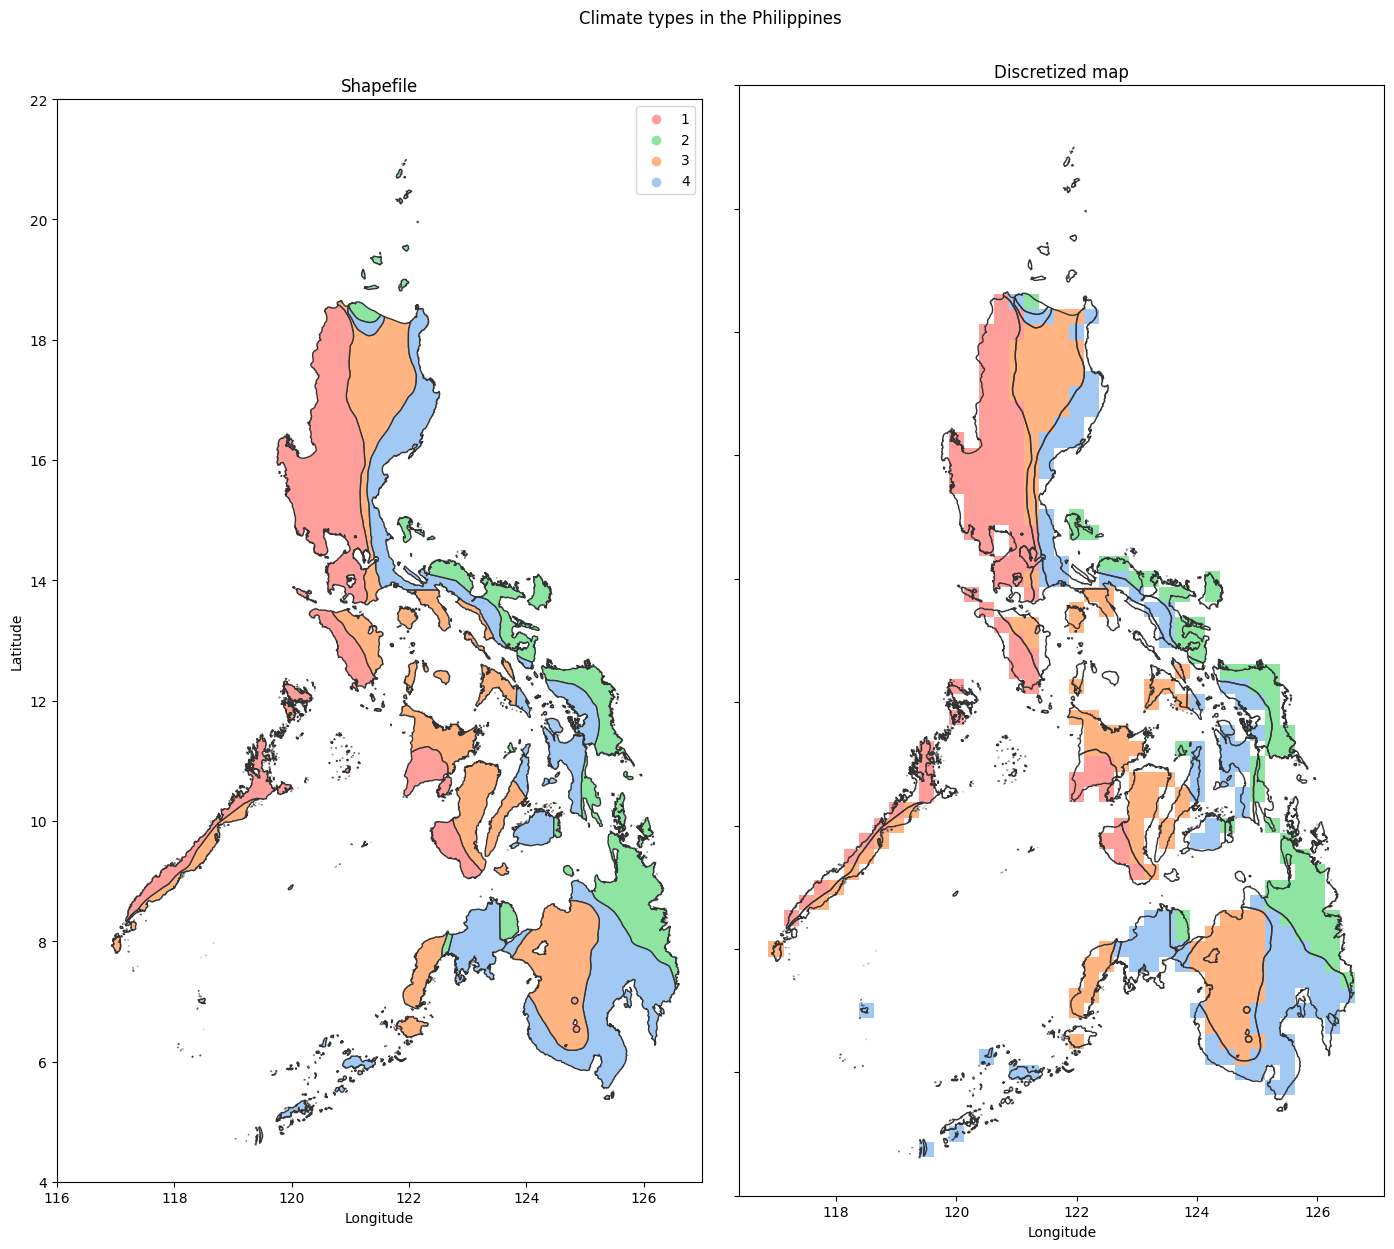

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 13), sharey=True)
plt.suptitle('Climate types in the Philippines')
plt.tight_layout()

## Climate type shapefile
# For color
PHL_type_copy = PHL_type.copy()
climate_colorlist = list(reversed([sns.color_palette("pastel")[type] for type in range(4)]))
color_dict_type = {i: cm.rgb2hex(climate_colorlist[i-1]) for i in range(1, 5)}
PHL_type_copy['color'] = PHL_type_copy['type'].map(color_dict_type)

# Plotting
PHL_type.plot(ax=ax1, edgecolor='#333333', color=PHL_type_copy['color']) # '#333333'
ax1.set_xlim(116, 127)
ax1.set_ylim(4, 22)
ax1.set_title('Shapefile')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Legend
def point(cluster):
  return ax1.scatter([1], [1], color=climate_colorlist[cluster-1])
ax1.legend(
    tuple([point(i) for i in range(1, 5)]),
    tuple([f'{i}' for i in range(1, 5)]),
    scatterpoints=1,
    loc='upper right',
    ncol=1,
    fontsize=10
)

## Climate type discretization
city_type_colors = list(map(color_dict_type.get, city_types['type'])) # it's important to put .get on the dictionary, otherwise it won't be callable
square_points.plot(ax=ax2, color=city_type_colors)
PHL_type.plot(ax=ax2, edgecolor='#333333', color='none') # '#333333' is a non-harsh black
ax2.set_title('Discretized map')
ax2.set_xlabel('Longitude')

So, we see that our discretized version is working smoothly. Now, let us group each rainfall data into their own climate types.

In [ ]:
# City type indices
cities_1, cities_2 = city_types[city_types['type']==1].index, city_types[city_types['type']==2].index
cities_3, cities_4 = city_types[city_types['type']==3].index, city_types[city_types['type']==4].index

# Rainfall
rainfall_1, rainfall_2 = rainfall_arr[cities_1, :], rainfall_arr[cities_2, :]
rainfall_3, rainfall_4 = rainfall_arr[cities_3, :], rainfall_arr[cities_4, :]

Now, let's try plotting the rainfall data and their errors.

In [ ]:
dates

DatetimeIndex(['2021-03-23', '2021-03-30', '2021-04-06', '2021-04-13',
               '2021-04-20', '2021-04-27', '2021-05-04', '2021-05-11',
               '2021-05-18', '2021-05-25',
               ...
               '2024-06-04', '2024-06-11', '2024-06-18', '2024-06-25',
               '2024-07-02', '2024-07-09', '2024-07-16', '2024-07-23',
               '2024-07-30', '2024-08-06'],
              dtype='datetime64[ns]', name='date', length=177, freq='7D')

Let us also add when the ENSO events are:
- La Nina: July 2020 - Mar 2023
- El Nino: July 2023 - Mar 2024

In [ ]:
def rainfall_plotter(ax, arr):
  # Mean and standard deviation
  mean_rainfall = np.array([np.std(arr[:, i]) for i in range(len(arr[0, :]))])
  std_rainfall = np.array([np.std(arr[:, i]) for i in range(len(arr[0, :]))])

  # Shade plot of ENSO events
  min_rainfall, max_rainfall = np.min(arr), np.max(arr)
  lanina_dates = pd.date_range('2021-03','2023-03' ,freq='7d')
  elnino_dates = pd.date_range('2023-07','2024-03' ,freq='7d')
  ax.fill_between(lanina_dates, min_rainfall, max_rainfall, color='blue', alpha=0.2)
  ax.fill_between(elnino_dates, min_rainfall, max_rainfall, color='red', alpha=0.2)

  # Plotting
  for i in range(len(arr)):
    ax.scatter(dates, arr[i], color='lightgray', alpha=0.2)

  # Error shade plot
  ax.plot(dates, mean_rainfall, color='black')
  ax.fill_between(dates, mean_rainfall+std_rainfall, mean_rainfall-std_rainfall, color='black', alpha=0.2)
  ax.tick_params(axis='x', labelrotation=45)

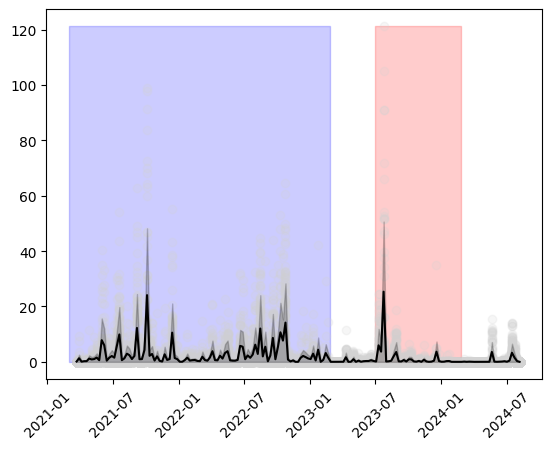

In [ ]:
fig, ax = plt.subplots()

rainfall_plotter(ax, rainfall_1)

and then let's view the mean and standard deviation of rainfall per each climate type together with the ENSO events.

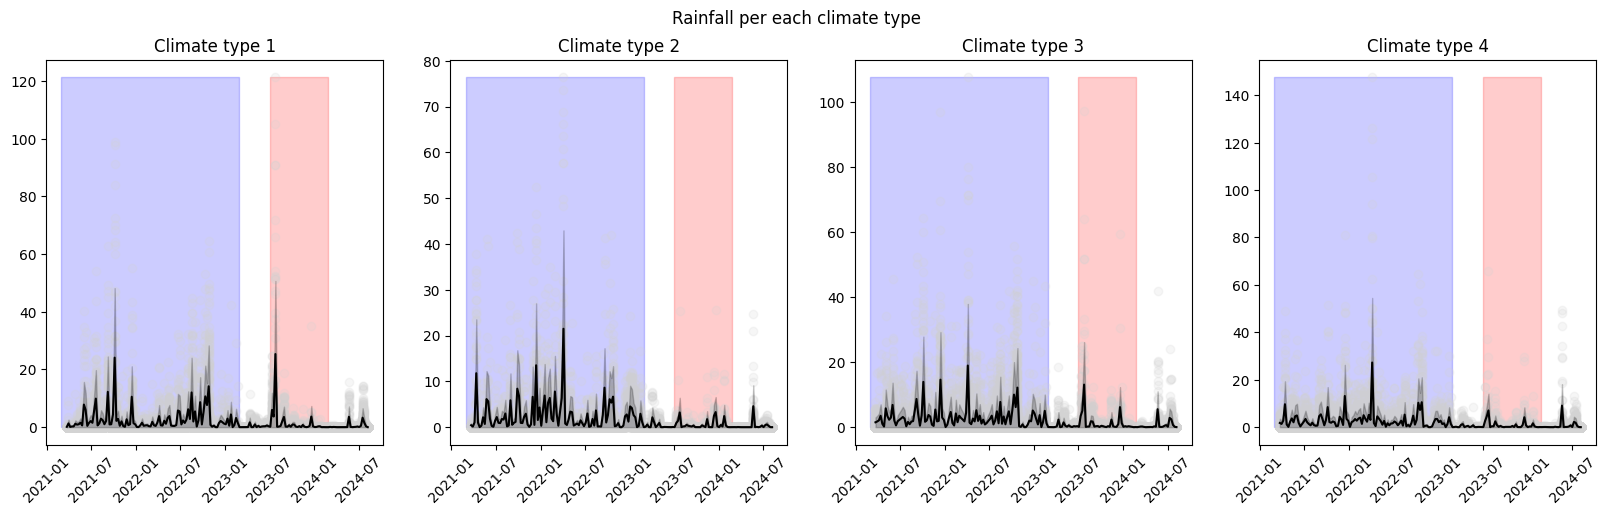

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
plt.suptitle('Rainfall per each climate type')

for i in range(4):
  axes = [ax1, ax2, ax3, ax4]
  ax = axes[i]
  ax.set_title(f'Climate type {i+1}')
rainfall_plotter(ax1, rainfall_1)
rainfall_plotter(ax2, rainfall_2)
rainfall_plotter(ax3, rainfall_3)
rainfall_plotter(ax4, rainfall_4)

In [ ]:
def rainfall_plotterrorbar(ax, arr):
  # Mean and standard deviation
  mean_rainfall = np.array([np.std(arr[:, i]) for i in range(len(arr[0, :]))])
  std_rainfall = np.array([np.std(arr[:, i]) for i in range(len(arr[0, :]))])

  # Shade plot of ENSO events
  min_rainfall, max_rainfall = np.min(arr), np.max(arr)
  lanina_dates = pd.date_range('2021-03','2023-03' ,freq='7d')
  elnino_dates = pd.date_range('2023-07','2024-03' ,freq='7d')
  ax.fill_between(lanina_dates, min_rainfall, max_rainfall, color='blue', alpha=0.2)
  ax.fill_between(elnino_dates, min_rainfall, max_rainfall, color='red', alpha=0.2)

  # Plotting
  for i in range(len(arr)):
    ax.scatter(dates, arr[i], color='lightgray', alpha=0.2)

  # Error shade plot
  ax.plot(dates, mean_rainfall, color='black')
  ax.errorbar(dates, mean_rainfall, std_rainfall, color='black')

  # Plotting
  #for i in range(len(arr)):
   # ax.scatter(dates, arr[i], color='lightblue', alpha=0.2)
  #ax.plot(dates, mean_rainfall, color='blue')
  #ax.errorbar(dates, mean_rainfall, std_rainfall)
  ax.tick_params(axis='x', labelrotation=45)

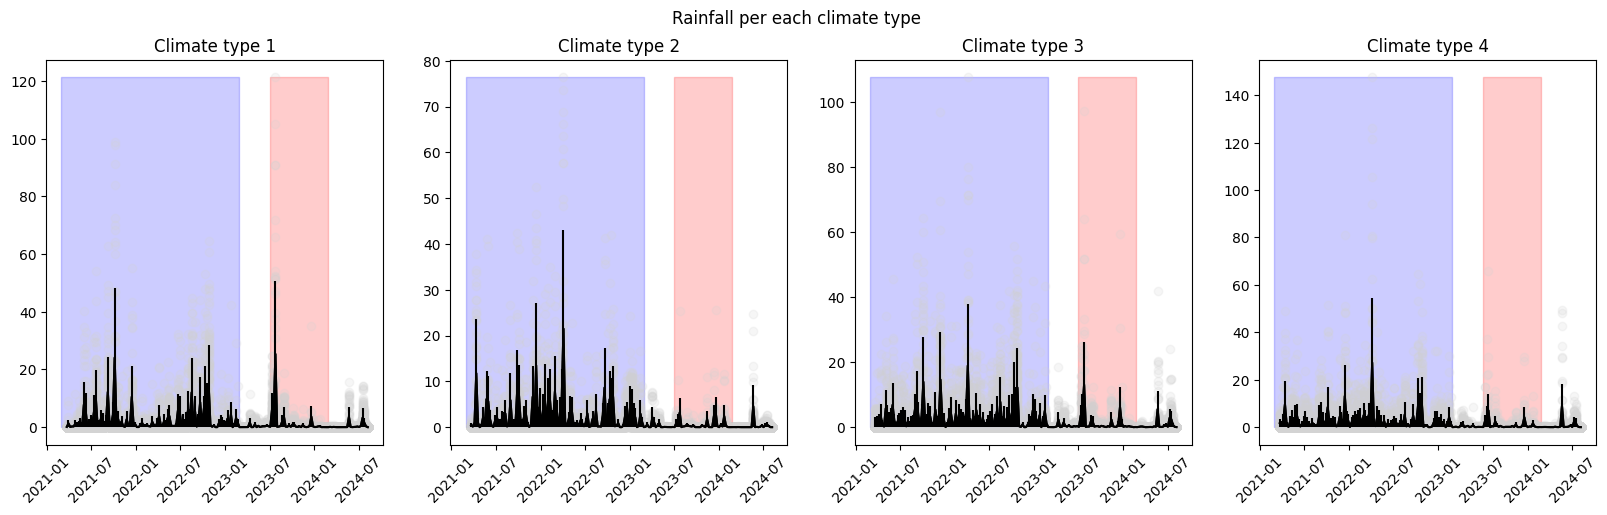

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
plt.suptitle('Rainfall per each climate type')

for i in range(4):
  axes = [ax1, ax2, ax3, ax4]
  ax = axes[i]
  ax.set_title(f'Climate type {i+1}')
rainfall_plotterrorbar(ax1, rainfall_1)
rainfall_plotterrorbar(ax2, rainfall_2)
rainfall_plotterrorbar(ax3, rainfall_3)
rainfall_plotterrorbar(ax4, rainfall_4)